# Image Classification - Final Project 🙌

### Hand Number Recognition

Rowan King, Lukas Schneider, Brendan McGuinness, Max Clark

### Libraries

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import os, shutil
import warnings
import cv2
from tqdm import tqdm
!pip install pydot
!pip install graphviz
warnings.filterwarnings('ignore')

### Setting up the data

For our project, we utilized a Kaggle dataset of hand images created by Shivam Aggarwal, designed for classifying the number of fingers being held up. Each image was labeled with one of six classes (0–5), corresponding to the number of fingers being held up. The images were provided in a slightly unconventional .h5 format, which required us to use some alternative packages to load them. While the dataset was free of missing or mislabeled data, there were some biases. All images came from the same individual, meaning the hands were of the same color and featured uniform backgrounds of plain white, with consistent quality. Although this made the dataset easier to process, it introduced concerns about the model's ability to generalize to diverse hand shapes, skin tones, or complex backgrounds. This limitation highlights potential challenges for deploying the model in real-world scenarios where such variability is common.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_dataset(data_path,samples_per_class=20):
    train_dataset = h5py.File(os.path.join(data_path, 'train.h5'), 'r')
    test_dataset  = h5py.File(os.path.join(data_path, 'test.h5'), 'r')

    X_train = train_dataset['train_set_x'][:]
    y_train = train_dataset['train_set_y'][:]
    classes = train_dataset['list_classes'][:]

    X_test  = test_dataset['test_set_x'][:]
    y_test  = test_dataset['test_set_y'][:]
    classes = test_dataset['list_classes'][:]

    return X_train, y_train, X_test, y_test, classes

In [ ]:
data_path  = '/content/drive/Shareddrives/PSTAT 134 - Final Project/HandSignsImages'
X_train, y_train, X_test, y_test, classes = load_dataset(data_path)

validation_size = 120 / X_train.shape[0] # Calculate proportion for validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=validation_size, stratify=y_train, random_state=42
)

print(f'number of training examples : {X_train.shape[0]}')
print(f'number of validation examples: {X_val.shape[0]}')  # Add validation set info
print(f'number of test examples     : {X_test.shape[0]}')
print(f'X_train : {type(X_train)} {X_train.shape}')
print(f'y_train : {type(y_train)} {y_train.shape}')
print(f'X_val   : {type(X_val)} {X_val.shape}')  # Add validation set info
print(f'y_val   : {type(y_val)} {y_val.shape}')  # Add validation set info
print(f'X_test  : {type(X_test)} {X_test.shape}')
print(f'y_test  : {type(y_test)} {y_test.shape}')
print(f'classes : {classes}')

number of training examples : 960
number of validation examples: 120
number of test examples     : 120
X_train : <class 'numpy.ndarray'> (960, 64, 64, 3)
y_train : <class 'numpy.ndarray'> (960,)
X_val   : <class 'numpy.ndarray'> (120, 64, 64, 3)
y_val   : <class 'numpy.ndarray'> (120,)
X_test  : <class 'numpy.ndarray'> (120, 64, 64, 3)
y_test  : <class 'numpy.ndarray'> (120,)
classes : [0 1 2 3 4 5]


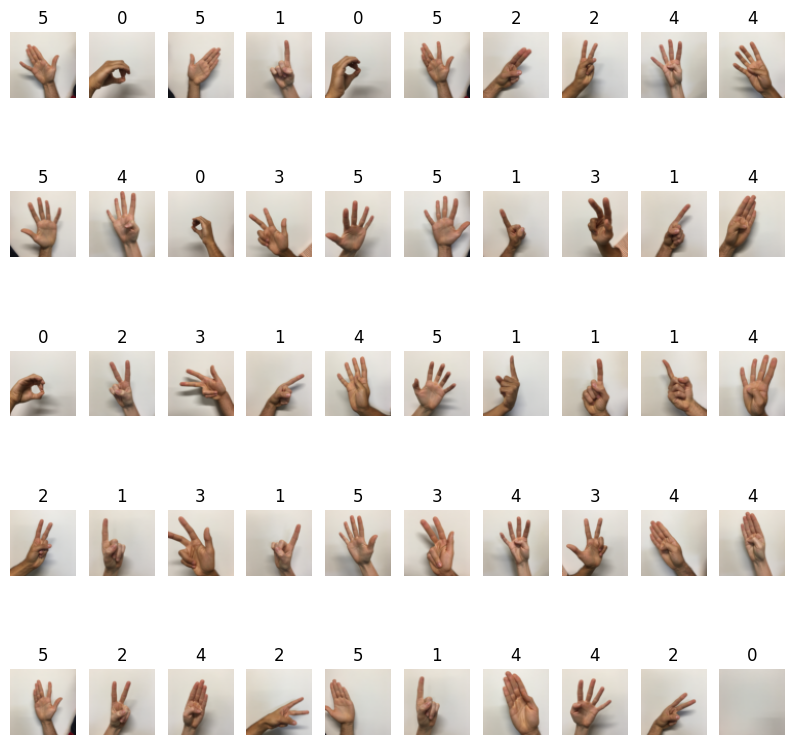

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(X_train[i])
    plt.title(classes[y_train[i]])
    plt.axis("off")

plt.show()

### Exploratory Data Analysis

The dataset was well-structured and pre-split into training and testing sets, with perfect class balance: the training set consisted of 1,080 images (180 per class), and the testing set included 120 images (20 per class). To create a validation set, we extracted 120 images from the training set, maintaining class balance.

In [ ]:
import numpy as np

# Calculate the number of occurrences of each class
unique_classes, class_counts = np.unique(y_train, return_counts=True)

Class Balance: Training Set
Class 0: 160 samples
Class 1: 160 samples
Class 2: 160 samples
Class 3: 160 samples
Class 4: 160 samples
Class 5: 160 samples
Class 0: 16.67%
Class 1: 16.67%
Class 2: 16.67%
Class 3: 16.67%
Class 4: 16.67%
Class 5: 16.67%


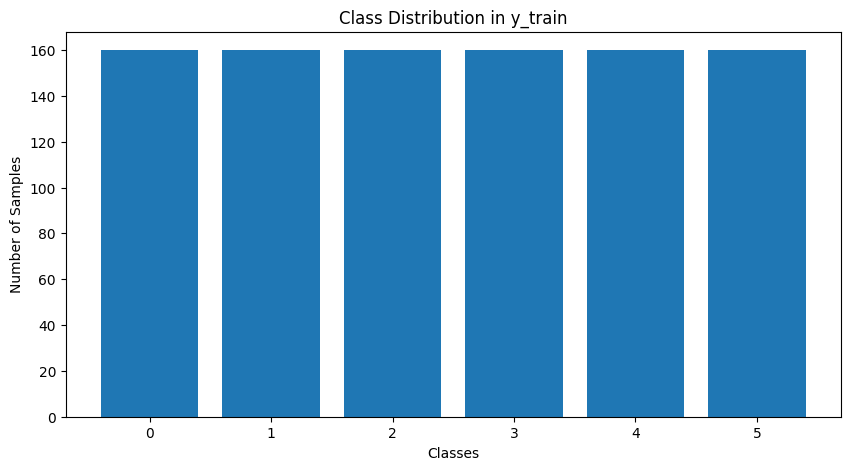

In [ ]:
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
plt.bar(unique_classes, class_counts)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in y_train")
plt.xticks(unique_classes)  # Set x-axis ticks to class labels
plt.show()

In [ ]:
# Calculate the number of occurrences of each class
unique_classes, class_counts = np.unique(y_val, return_counts=True)

print('Class Balance: Validation Set')
# Print the class balance
for cls, count in zip(unique_classes, class_counts):
  print(f"Class {cls}: {count} samples")

# Optional: Calculate and print class percentages
total_samples = len(y_val)
for cls, count in zip(unique_classes, class_counts):
  percentage = (count / total_samples) * 100
  print(f"Class {cls}: {percentage:.2f}%")

Class Balance: Validation Set
Class 0: 20 samples
Class 1: 20 samples
Class 2: 20 samples
Class 3: 20 samples
Class 4: 20 samples
Class 5: 20 samples
Class 0: 16.67%
Class 1: 16.67%
Class 2: 16.67%
Class 3: 16.67%
Class 4: 16.67%
Class 5: 16.67%


In [ ]:
# Calculate the number of occurrences of each class
unique_classes, class_counts = np.unique(y_test, return_counts=True)

print('Class Balance: Testing Set')
# Print the class balance
for cls, count in zip(unique_classes, class_counts):
  print(f"Class {cls}: {count} samples")

# Optional: Calculate and print class percentages
total_samples = len(y_test)
for cls, count in zip(unique_classes, class_counts):
  percentage = (count / total_samples) * 100
  print(f"Class {cls}: {percentage:.2f}%")

Class Balance: Testing Set
Class 0: 20 samples
Class 1: 20 samples
Class 2: 20 samples
Class 3: 20 samples
Class 4: 20 samples
Class 5: 20 samples
Class 0: 16.67%
Class 1: 16.67%
Class 2: 16.67%
Class 3: 16.67%
Class 4: 16.67%
Class 5: 16.67%


### Image Data Generator

We opted to keep the transformation of the images simple, including only the rescaling of the RGB parameters onto a scale of [0,1].

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_gen.flow(X_train, y_train,
                                 batch_size=5,
                                 #class_mode='categorical')
)

val_gen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_gen.flow(X_val, y_val,
                             batch_size=5,
                             #class_mode='categorical')
)

test_gen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_gen.flow(X_test, y_test,
                               batch_size=5,
                               #class_mode='categorical')
)

### Building the Model

In building our model we decided to follow the same sequence as the one we learned in class. Thus, our model has 7 layers including a 2D convolutional input layer with a ReLU activation function, a max pooling layer for 2D spatial data, another 2D convolutional layer with ReLU activation, another max pooling layer for 2D spatial data, a flattening layer, a dense layer with 128 units and ReLU activation, and a dense output layer with softmax activation.

In [ ]:
model = Sequential()

#1
model.add(Conv2D(filters=32, kernel_size=3, strides=1,
                 padding='same', activation='relu',
                 input_shape=[64, 64, 3]))
#2
model.add(MaxPooling2D(2, ))
#3
model.add(Conv2D(filters=64, kernel_size=3, strides=1,
                 padding='same', activation='relu'))
#4
model.add(MaxPooling2D(2))
#5
model.add(Flatten())
#6
model.add(Dense(128, activation='relu'))
#7
model.add(Dense(6, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,117,446 (8.08 MB)

 Trainable params: 2,117,446 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

We then trained our convoluted neural network on the training data using our validation set for cross-validation. Additionally, we used Adam and categorical cross-entropy, and after 12 epochs our model achieved 100% accuracy. This is a red flag as it raises large suspicions for over-fitting.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=12, verbose=1,
                 validation_data=val_generator,
                 batch_size = 5, validation_steps=120//5,
                 callbacks=early_stopping)

Epoch 1/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1899 - loss: 1.9373 - val_accuracy: 0.5833 - val_loss: 1.1906
Epoch 2/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.6208 - loss: 0.9947
Epoch 3/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8149 - loss: 0.5409 - val_accuracy: 0.8417 - val_loss: 0.4253
Epoch 4/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9107 - loss: 0.2502
Epoch 5/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.9640 - loss: 0.1399 - val_accuracy: 0.9000 - val_loss: 0.3452
Epoch 6/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9713 - loss: 0.0943
Epoch 7/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.9724 - loss: 0.0855 - val_accuracy: 0.8583 - val_loss: 0.3069
Epoch 8/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.9846 - loss: 0.0381
Epoch 9/12
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9826 - loss: 0.0441 - val_accuracy: 0.9000 - val_loss: 0.2

### Accuracy/Loss Plot

Looking at the plot for loss and accuracy we see that in the fitting process our model initially made enormous progress in terms of accuracy, before slowing down as it approached 100%. By the 4th epoch the model already had an accuracy of 91%, but it took the remaining 8 epochs to gain the other 9%

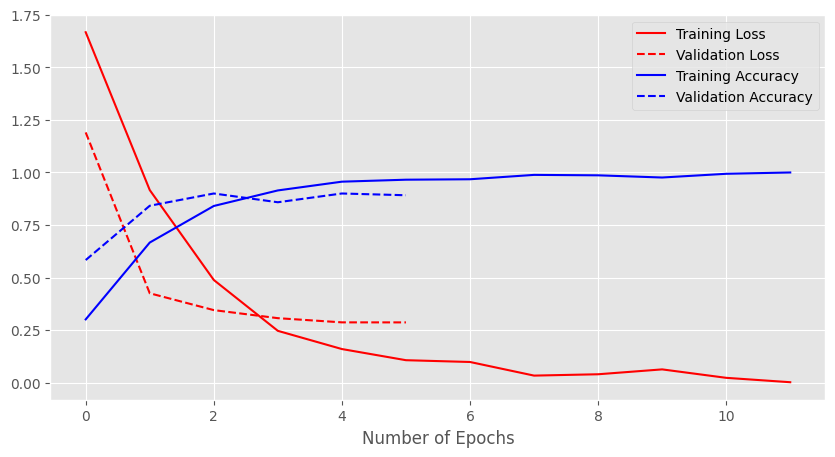

In [ ]:
# plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

### Test results

Having fit our model to the testing data we found that the test accuracy was 0.9083. This is roughly 10% lower than the training error, however we suspected this would occur due to overfitting.

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9090 - loss: 0.4070
Test Loss: 0.3267
Test Accuracy: 0.9083


Looking at the confusion matrix we see that the model did exceptionally well on zeros and fives, and worst on fours and threes. It is also important to note that while the model correctly identified fives 90% of the time, it also guessed five the most out of any other number. To be specific the model guessed five 25 times, while the next closest guesses were two and four with 20 guesses each.

In [ ]:
predictions = model.predict(X_test)     # vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # we take the highest probability

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


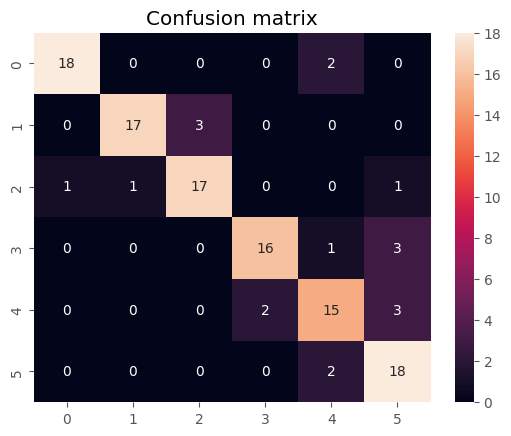

In [ ]:
CM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=classes,
           yticklabels=classes, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

If we take a look at the select few of mislabeled images we can search for specific reasons these images were missed. From the plot of mislabeled images it becomes apparent that the model does poorly when the hand is holding up a four with the palm facing the camera. This is likely because the thumb is still present in the image, although not elevated, so the model counts it as the fifth finger. This also seems to be the case for threes with the thumb, index, and middle fingers, with the palm facing the camera. These images still show the ring and pinky fingers, and despite them not being raised, they clearly impact the decision of the model. Circling back to the confusion matrix, we may have found our explanation for why the model was so successful with fives and so unsuccessful with threes and fours.

In [ ]:
def display_examples(class_names, images, labels):

    num_images = min(25, len(images))

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Mislabeled Images:", fontsize=16)
    for i in range(num_images):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [ ]:
def print_mislabeled_images(classes, X_test, y_test, pred_labels):

    BOO = (y_test == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = X_test[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    display_examples(classes,  mislabeled_images, mislabeled_labels)

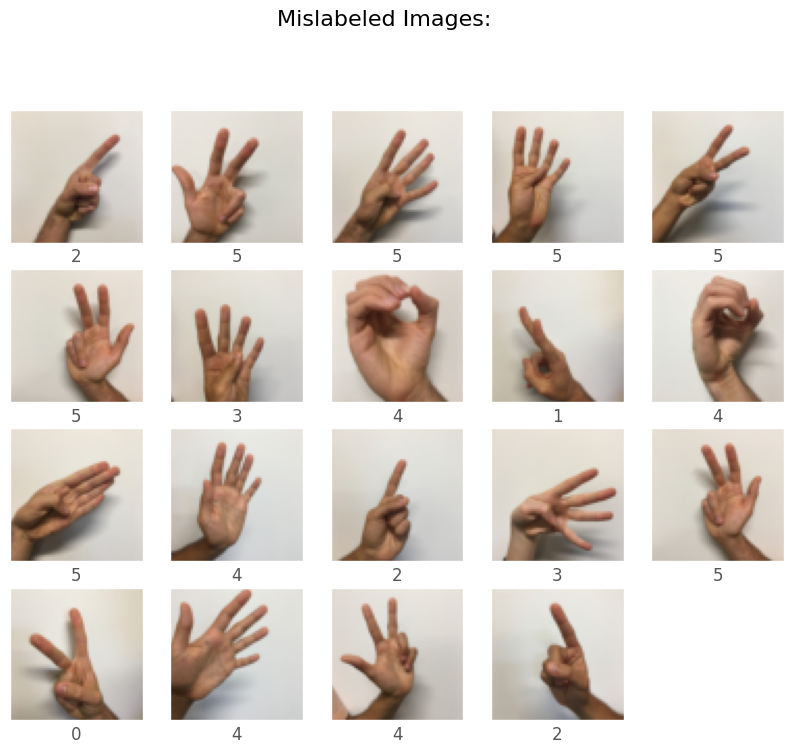

In [ ]:
print_mislabeled_images(classes, X_test, y_test, pred_labels)

### Fitting Model To Our Own Images

Although our model performed fairly well with the test data from Shivam’s data set, we still had concerns with the model's applications due to the uniformity of images it was trained and tested on. Thus, we assembled our own testing set of pictures of our own hands that was designed to be challenging for the model. This set contained 60 images with 10 belonging to each class.

In [ ]:
class_names = ['0', '1', '2', '3', '4', '5']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

image_size = (64, 64)

def load_data():

    datasets = ["/content/drive/Shareddrives/PSTAT 134 - Final Project/HandSignsImages/jpeg_images"]
    output = []

    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        output.append((images, labels))

    return(output)

In [ ]:
(test_image, test_label) = load_data()[0]

Loading /content/drive/Shareddrives/PSTAT 134 - Final Project/HandSignsImages/jpeg_images


100%|██████████| 10/10 [00:00<00:00, 148.58it/s]


In examining the first 25 pictures in our set we see the nature of these challenges. First and foremost we experimented with varying hand positions for each number. This includes the angle at which the hand is held in relation to the camera, as well as which fingers are raised to signify the number. We also included varying backgrounds to combat the identical backgrounds in the source set. The final, unintentional challenge that we created for our model is in the size of the pictures themselves. The source images came in a size of 64 pixels by 64 pixels, thus we had to resize our own pictures to fit this model parameter. In doing so the images lost significant clarity.

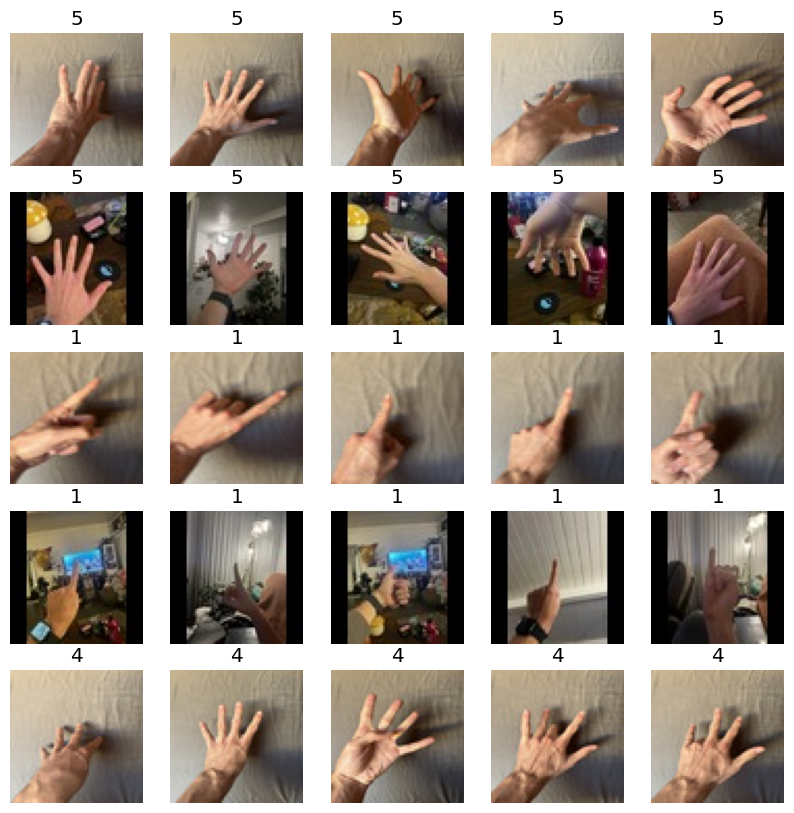

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_image[i])
    plt.title(classes[test_label[i]])
    plt.axis("off")

plt.show()

After fitting our model to the new set our concerns were proven valid. The model successfully classified just 14 of the 60 images, meaning our accuracy was 23.3%. The most guessed number was three, including a whopping 8 times when the true label was five.

In [ ]:
test_image = test_image / 255.0

In [ ]:
predictions = model.predict(test_image)     # vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # we take the highest probability

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


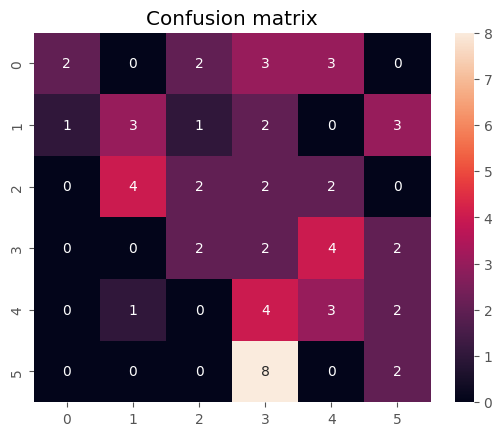

In [ ]:
CM = confusion_matrix(test_label, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()


There appears to be no clear pattern in these images that were mislabeled as three. Possible features that contributed to the inaccuracy may have included the varying lighting of the images, especially shadows. In a handful of cases fingers were nearly completely obscured in darkness, thus it seems reasonable that this impacted the results.


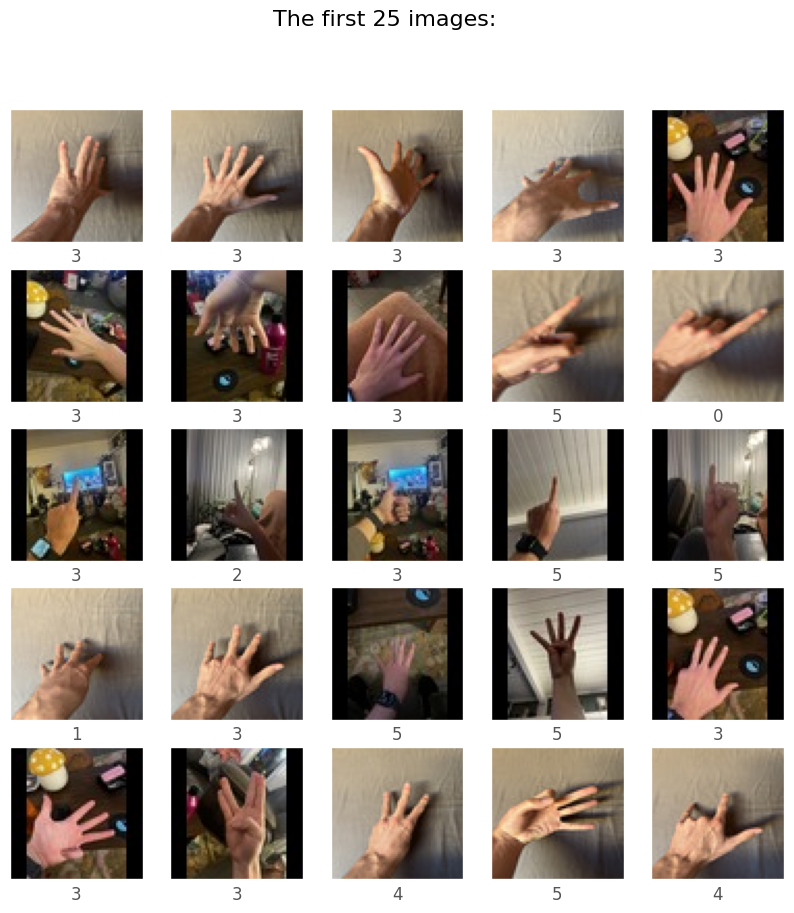

In [ ]:
print_mislabeled_images(classes, test_image, test_label, pred_labels)

### Conclusion

In order to make the model more successful at predicting non-uniform images – barring augmenting the training set with such pictures – it may be helpful to impose further transformations in the image data generator step. Given the opportunity to perform this project again we would like to experiment with grey-scaling the images in order to minimize the effect that the background has on the image predictions. Overall, the initial results of our model were above expectations for the initial purpose of the data set, but attempting to apply our model further unveiled limitations.